In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from generation_parameters import get_params
from db_config import DBConfig
from scipy.io import loadmat
import os
import h5py
import pickle

import pyroomacoustics as pra
from pyroomacoustics import directivities as dr
from pyroomacoustics.experimental.rt60 import measure_rt60
import argparse

In [5]:
import room_sim
import tau_loading

In [24]:
tau_db_dir = "/scratch/ci411/TAU_SRIR_DB/TAU-SRIR_DB"
mat_files = os.listdir(tau_db_dir)
room_name = 'sc203'
mat_file = [filename for filename in mat_files if room_name in filename][0]

In [25]:
mat_file

'rirs_06_sc203.mat'

In [4]:
#%load_ext autoreload
%autoreload 2

Estimated rt60: 3.644933333333333


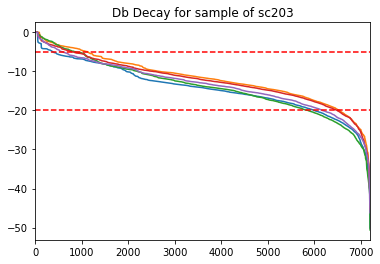

In [27]:
#estimate RT60 of a given room via schroeder's method
#note that decay_db should be 60, but most RIRs are truncated
#before this drop, so we use a shorter method (assuming the
#db falloff is roughly linear)

rir_file = '/scratch/ci411/TAU_SRIR_DB/TAU-SRIR_DB/rirs_06_sc203.mat'
#custom function for sampling TAU-SRIR database for RIRs
rir_samples = tau_loading.load_rir_sample(rir_file, t_type='linear')
decay_db = 15
sr = 24000

#visualize our rt60 estimations
fig = plt.figure()
plt.title("Db Decay for sample of sc203")
ax = plt.gca()

rt_estimates = []
for i in range(rir_samples.shape[0]):
    rt_estimates.append(room_sim.measure_rt60(rir_samples[i], fs=sr, decay_db=decay_db))
    room_sim.plot_energy_db(ax, rir_samples[i,:])

plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)

rt_estimates = np.array(rt_estimates) * (60/decay_db)
rt_avg = np.average(rt_estimates)
print(f"Estimated rt60: {rt_avg}")

In [145]:
#determine absorption coefficients, necessary max order of reflections
#given estimated room dimensions, estimated rt60
#define room

room_dim = [11,8,4]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_sc203 = pra.ShoeBox(
    room_dim, fs=sr, materials=pra.Material(e_absorption), max_order=max_order
)

In [146]:
#define mic geometry
mic_coords, mic_dirs = room_sim.get_tetra_mics()

In [147]:
#grab paths from tau_srir
tau_db_dir = '/scratch/ci411/TAU_SRIR_DB/TAU-SRIR_DB'
room_idx = 5

paths, paths_meta, room_meta = room_sim.load_tau_paths(5, tau_db_dir)

In [148]:
#center mic coordinates based on array center location
mic_loc_center = np.array([0.05, 0.05, 0.05])
mic_locs = room_sim.center_mic_coords(mic_coords, mic_loc_center)

In [152]:
room_center = np.array([room_dim[0]/2, room_dim[1]/2, 0])
#choose path based on traj/height:
t_idx = 0
h_idx = 4
path = paths[t_idx][h_idx]
mic_center = room_meta['microphone_position'] + room_center
centered_path = path + mic_center
centered_mics = mic_locs + mic_center

room_sc203.add_microphone_array(centered_mics.T, directivity=mic_dirs)
for source in centered_path:
    room_sc203.add_source(source)

(0.0, 4.4)

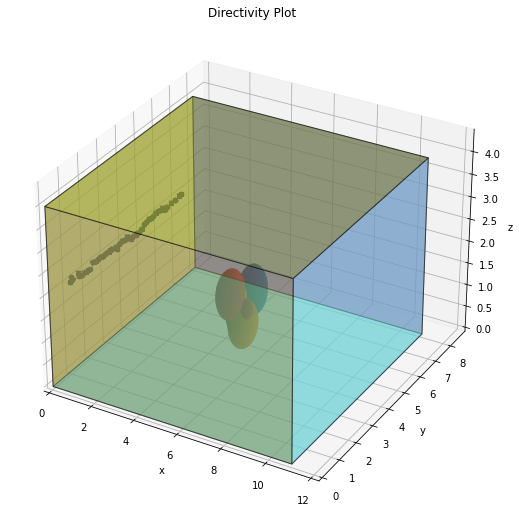

In [151]:
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
room_sc203.plot(ax=ax)
ax.set_xlim(0,room_dim[0]*1.1)
ax.set_ylim(0,room_dim[1]*1.1)
ax.set_zlim(0,room_dim[2]*1.1)

In [ ]:
room_sc203.compute_rir()

In [ ]:
n_traj = len(paths)
n_heights = len(paths[0])

